In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### image test code

In [10]:
# 이미지 데이터 경로 설정
train_data_dir = 'face_sample'  # 폴더 경로 설정 (350장 테스트)
input_shape = (224, 224)
batch_size = 32
num_classes = 7  # 클래스 개수에 맞게 설정

# 데이터셋 생성
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,  # 각 픽셀 값을 0에서 1 사이로 변환
)

In [6]:
# 디렉토리에서 이미지 데이터를 로드하고 전처리된 이미지 배치 생성
train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical' 
    # class_mode를 'categorical'로 설정하면 클래스 레이블은 알파벳 순서로 자동 지정됨
    # 클래스 레이블 순서가 예상과 다를 경우, 모델의 예측과 실제 클래스 간의 오류가 발생할 수 있음
)


# 모델에 데이터를 넣는 시작점
# input_shape가 (224, 224)니까 shape은 (224, 224, 3)가 됨
input_layer = layers.Input(shape=(*input_shape, 3), dtype='float32', name='input')


# DenseNet121 모델을 생성하고, imagenet 데이터셋으로 사전 훈련된 가중치를 적용함
densenet_model = DenseNet121(input_tensor=input_layer, weights='imagenet')

# 다차원 배열(텐서)을 1차원 배열로 평탄화
flatten = layers.Flatten()(densenet_model.output)

# 다중 클래스 분류니까 소프트맥스 활성화 함수
output_layer = layers.Dense(num_classes, activation='softmax')(flatten)

# 모델 만들기 (입력 데이터를 받아 예측을 수행하고, 다중 클래스 분류를 위해 확률 분포를 출력할 준비)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='categorical_crossentropy',  
              metrics=['acc'])

# 모델 요약 출력              
model.summary()

# 모델 학습
epochs = 10  # 적절한 epoch 수를 설정
model.fit(train_generator, epochs=epochs)

Found 350 images belonging to 7 classes.


33188688/33188688 [==============================] - 14s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input[0][0]']               
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati 

In [16]:
# 클래스 이름과 인덱스 매핑 출력
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surpeise': 6}


1/1 [==============================] - 0s 119ms/step


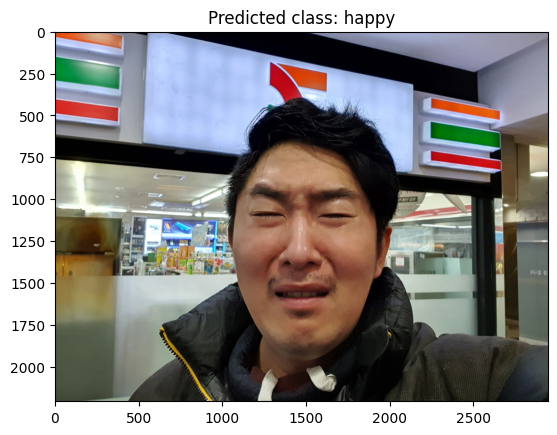

In [17]:
# 이미지를 하나 테스트 해보자

# 테스트할 이미지 경로 설정
test_image_path = 'test.jpg'  # 테스트 이미지 경로
target_size = (224, 224)  # 모델 입력 크기와 일치되게 입력

# 이미지 불러오기 및 전처리
test_image = load_img(test_image_path, target_size=target_size)
test_image = img_to_array(test_image)
test_image = test_image.astype(np.float32) / 255.0
test_image = np.expand_dims(test_image, axis=0)  # 배치 차원 추가

# 모델 예측 수행
predictions = model.predict(test_image)

# 클래스 이름과 인덱스 매핑
class_names = list(train_generator.class_indices.keys())
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]

# 결과 표시
plt.imshow(load_img(test_image_path))
plt.title(f'Predicted class: {predicted_class_name}')
plt.show()
